In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import sklearn.neighbors as skln
import gc

rng = np.random.default_rng(seed=67)
plt.rcParams["figure.figsize"] = (8,5)

In [3]:
def l1_norm(a):
    return np.linalg.norm(a, 1)

def l1_norm_int(a):
    return int(np.rint(np.abs(a).sum()))

In [4]:
delta = 1/1000
n = 1000
d = 300 # at least log n ** 2?
r1 = d // 10
r2 = d // 5
k = np.floor(-np.log(n) / np.log(1 - r2 / d))
rho = np.log(1 - r1/d) / np.log(1 - r2/d)
l = int(np.ceil(np.power(n, rho) * np.log(1/delta)))

In [5]:
n, l, k, rho, r1, r2

(1000, 181, 30.0, 0.4721647344828152, 30, 60)

In [6]:
class HammingLSH:
    def __init__(self, points, r1, r2, delta=None, l=None, random_gen=rng):
        assert l is None or delta is None
        assert np.issubdtype(points.dtype, np.signedinteger)
        assert ((points == 0) | (points == 1)).all()
        self._d = points.shape[1]
        self._n = points.shape[0]
        self._r1 = r1
        self._r2 = r2
        self._k = int(np.floor(-np.log(self._n) / np.log(1 - r2 / self._d)))
        self._rho = np.log(1 - r1/self._d) / np.log(1 - r2/self._d)
        if l is None:
            self._l = int(np.ceil(np.power(self._n, self._rho) * np.log(1/delta)))
        else:
            self._l = l
            
        self._populate(points, random_gen)
        
    def _populate(self, points, random_gen):
        self._buckets = [dict() for i in range(self._l)]
        self._g_support = [random_gen.choice(self._d, self._k, replace=True) for i in range(self._l)]
        for p in points:
            for i in range(self._l):
                bucket = p[self._g_support[i]]
                if not bucket.tobytes() in self._buckets[i]:
                    self._buckets[i][bucket.tobytes()] = p
    
    def _validate_point(self, p):
        assert p.dtype == points.dtype
        assert ((p == 0) | (p == 1)).all()
        assert len(p) == self._d
        
    def query(self, q):
        self._validate_point(q)
        for i in range(self._l):
            bucket = q[self._g_support[i]]
            p = self._buckets[i].get(bucket.tobytes())
            if p is not None and np.linalg.norm(p - q, 1) <= r2:
                return p
        return None
    
    def cnt_mutual_buckets(self, q, z):
        self._validate_point(q)
        self._validate_point(z)
        ans = 0
        for i in range(self._l):
            q_buck = q[self._g_support[i]]
            z_buck = z[self._g_support[i]]
            if np.array_equal(q_buck, z_buck):
                ans += 1
        return ans
    
    def cnt_good_buckets(self, z):
        self._validate_point(z)
        ans = 0
        for i in range(self._l):
            z_buck = z[self._g_support[i]]
            if np.array_equal(z, z_buck):
                ans += 1
        return ans
                

## Success chance tests

In [18]:
points = np.zeros((n, d), dtype=int)

lsh = HammingLSH(points, r1, r2, delta)

In [27]:
grid = np.arange(r2 + 2)
vals = np.zeros(r2 + 2)
for dist in tqdm(grid):
    repeats = 100
    success = 0
    for j in range(repeats):
        for j in range(300):
            q = np.zeros(d, dtype=int)
            q[rng.choice(d, dist, replace=False)] = 1
            res = lsh.query(q)
            if res is None:
                success += 1
                break
    vals[dist] = success / repeats

  0%|          | 0/62 [00:00<?, ?it/s]

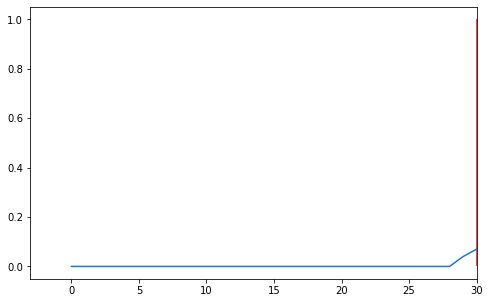

In [28]:
plt.plot(grid, vals)
plt.vlines([r1], 0, 1, colors=['red'])
plt.xlim(None, 30)
plt.show()

In [10]:
print("Success rate at r1:", vals[r1])

Success rate at r1: 1.0


# Breaking hamming LSH faster

In [6]:
t = 10

In [7]:
print(r1, r2, t, n, d)

30 60 10 1000 300


In [9]:
points = np.repeat(np.random.binomial(1, 0.5, size=d)[:, None], n, axis=1).T
# np.ones((n, d), dtype=int)

nn_checker = skln.KDTree(points, metric='l1')
lsh = HammingLSH(points, r1, r2, delta)

In [7]:
def run_exp_fast(z, t, nn_checker, lsh, target_distance=r1, max_resamples=1):
    found_error = False
    error_query = None
    total_queries = 0

    def make_query(q):
        nonlocal total_queries
        total_queries += 1
        res2 = lsh.query(q)
        return res2
    
    def check_query(q):
        res_dist, res1 = nn_checker.query(q[None, :], return_distance=True)
        res2 = make_query(q)
        if res_dist[0] <= r1 and res2 is None or res2 is not None and l1_norm(res2 - q) > r2:
            nonlocal found_error, error_query
            found_error = True
            error_query = q
        return res2

    def flip_bits(p, mask):
        p[mask] = 1 - p[mask]
    
    dist = r1 - t
    num_resample = 0
    inner_iterations = 0
    max_inner_iterations = 3 * (target_distance - dist + 1)
    while not found_error and num_resample < max_resamples:
        num_resample += 1
        q = z.copy()
        flip_bits(q, rng.choice(d, dist, replace=False))

        while l1_norm_int(q - z) < target_distance:
            if check_query(q) is None:
                break
            q1 = np.copy(q)
            next_bit = None
            found_bit = False

            failed = True
            while inner_iterations < max_inner_iterations:
                inner_iterations += 1
                qr = np.copy(q1)
                flip_bits(qr, rng.choice(np.argwhere(q1 == z), r2 - l1_norm_int(q1 - z), replace=False).flatten())
                if make_query(qr) is None:
                    failed = False
                    break

            if failed:
                break

            ql = q1

            while l1_norm_int(qr - ql) > 1:
                qm = np.copy(ql)
                flip_bits(qm, rng.choice(np.argwhere(qr != ql), l1_norm_int(qr - ql) // 2, replace=False).flatten())
                if make_query(qm) is None:
                    qr = qm
                else:
                    ql = qm

            flip_bits(q, np.argwhere(qr != ql)[0])
        #         print("Found bit at dist", l1_norm(qr))
            if found_error:
                break

#     print("norm of q:", l1_norm(q))
#     print(found_error)
#     if found_error:
#         print(l1_norm(error_query))
#         print(total_queries)
#         print(lsh.query(error_query))
    return found_error, total_queries, l1_norm(q), error_query

In [19]:
run_exp_fast(points[0], 30, nn_checker, lsh)

(True,
 206,
 136.0,
 array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1,
        0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 1, 1, 

### Analysing dependance on t

In [29]:
points = np.repeat(np.random.binomial(1, 0.5, size=d)[:, None], n, axis=1).T

nn_checker = skln.KDTree(points, metric='l1')
lsh = HammingLSH(points, r1, r2, delta)

t_grid = np.arange(0, r1 + 1, 1)
iters_per_point = 300
res = []
for t1 in tqdm(t_grid):
    cur_res = []
    for i in range(iters_per_point):
        cur_res.append(run_exp_fast(points[0], t1, nn_checker, lsh))
    res.append(cur_res)

  0%|          | 0/31 [00:00<?, ?it/s]

In [30]:
failure_prob = []
mean_queries = np.zeros(len(res))
err_queries = np.zeros(len(res))
# bars_queries = [np.zeros(len(res)), np.zeros(len(res))]
for i, v in enumerate(res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v if e[0]]
    if len(queries) == 0:
        queries = [0]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)

# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

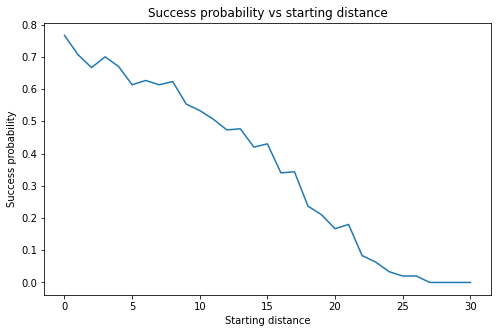

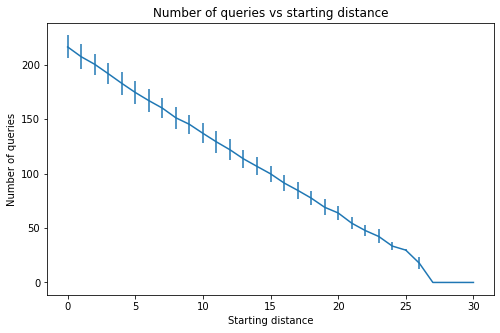

In [33]:
plt.plot(r1 - np.flip(t_grid), 1 - np.flip(failure_prob))
plt.title("Success probability vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(r1 - np.flip(t_grid), np.flip(mean_queries), yerr=np.flip(err_queries))
plt.title("Number of queries vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Number of queries")
plt.show()

### Dependance on $t$ with random points

In [37]:
points = np.random.binomial(1, 0.5, size=(n, d))

nn_checker = skln.KDTree(points, metric='l1')
lsh = HammingLSH(points, r1, r2, delta)

t_grid = np.arange(0, r1 + 1, 1)
iters_per_point = 300
res = []
for t1 in tqdm(t_grid):
    cur_res = []
    for i in range(iters_per_point):
        cur_res.append(run_exp_fast(points[0], t1, nn_checker, lsh))
    res.append(cur_res)

  0%|          | 0/31 [00:00<?, ?it/s]

In [38]:
failure_prob = []
mean_queries = np.zeros(len(res))
err_queries = np.zeros(len(res))
# bars_queries = [np.zeros(len(res)), np.zeros(len(res))]
for i, v in enumerate(res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v if e[0]]
    if len(queries) == 0:
        queries = [0]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)

# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

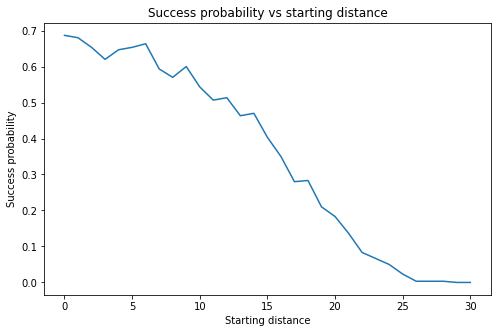

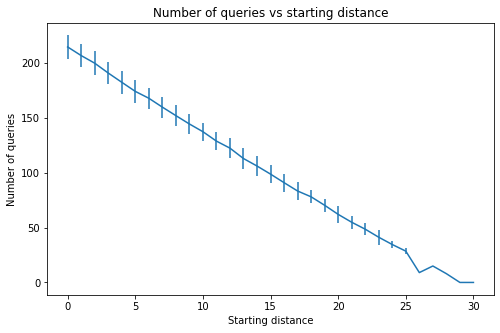

In [39]:
plt.plot(r1 - np.flip(t_grid), 1 - np.flip(failure_prob))
plt.title("Success probability vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(r1 - np.flip(t_grid), np.flip(mean_queries), yerr=np.flip(err_queries))
plt.title("Number of queries vs starting distance")
plt.xlabel("Starting distance")
plt.ylabel("Number of queries")
plt.show()

### Analysing dependance on radius

In [108]:
r_grid = np.arange(0, r1 + 1, 1)
iters_per_point = 1000
r_res = []
for rp in tqdm(r_grid):
    cur_res = []
    for i in range(iters_per_point):
        cur_res.append(run_exp_fast(r1, target_distance=rp))
    r_res.append(cur_res)

  0%|          | 0/31 [00:00<?, ?it/s]

In [109]:
failure_prob = []
mean_queries = np.zeros(len(r_res))
err_queries = np.zeros(len(r_res))
# bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(r_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

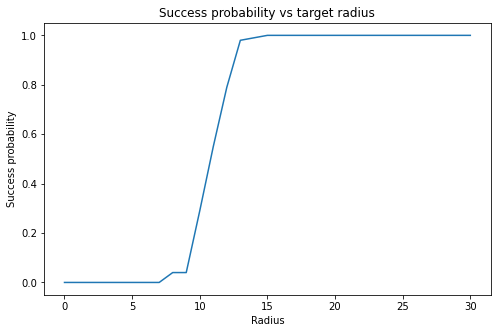

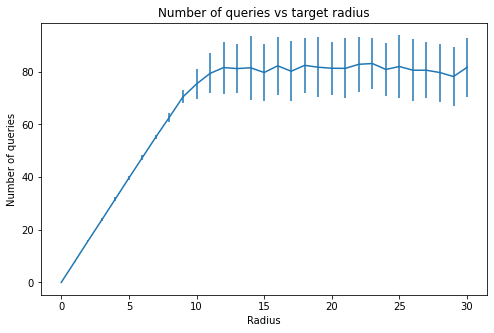

In [110]:
plt.plot(r_grid, 1 - np.array(failure_prob))
plt.title("Success probability vs target radius")
# plt.yscale("log")
plt.xlabel("Radius")
plt.ylabel("Success probability")
plt.show()

# plt.errorbar(r_grid, mean_queries, yerr=bars_queries)
plt.errorbar(r_grid, mean_queries, yerr=err_queries)
plt.title("Number of queries vs target radius")
plt.xlabel("Radius")
plt.ylabel("Number of queries")
plt.show()

### Search for infliction point

In [122]:
delta_list = np.exp(-np.arange(1, 11, 3),)
points = np.zeros((n, d), dtype=int)

all_res = []

for dl in delta_list:
    lsh = HammingLSH(points, r1, r2, dl)
    r_grid = np.arange(0, r1 + 1, 1)
    iters_per_point = 1000
    r_res = []
    for rp in tqdm(r_grid):
        cur_res = []
        for i in range(iters_per_point):
            cur_res.append(run_exp_fast(r1, target_distance=rp))
        r_res.append(cur_res)
    all_res.append(r_res)

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

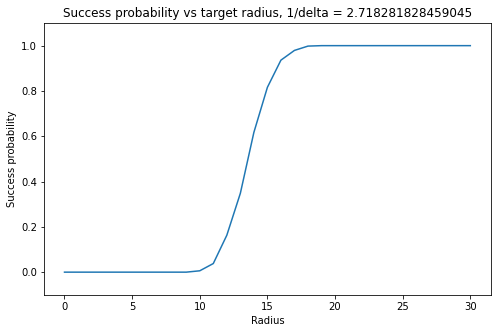

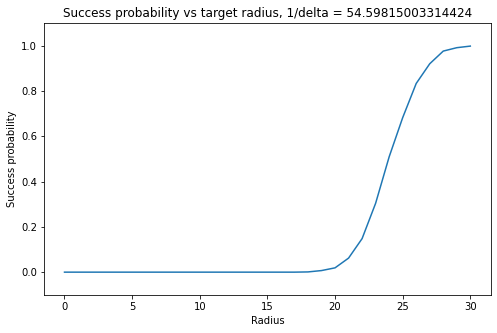

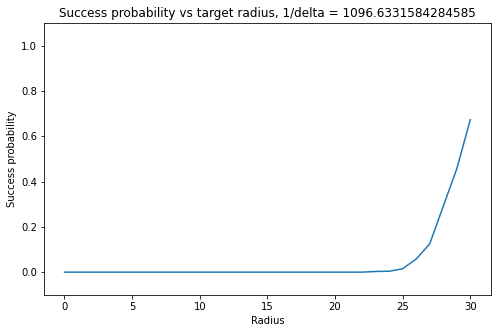

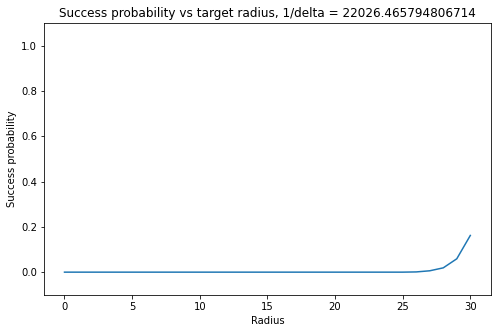

In [125]:
for r_res, dl in zip(all_res, delta_list):
    failure_prob = []
    # mean_queries = np.zeros(len(r_res))
    # err_queries = np.zeros(len(r_res))
    for i, v in enumerate(r_res):
        f_pr = sum(1 - e[0] for e in v) / len(v)
        failure_prob.append(f_pr)
    #     queries = [e[1] for e in v]
    #     mean_queries[i] = np.mean(queries)
    #     err_queries[i] = np.std(queries)


    plt.plot(r_grid, 1 - np.array(failure_prob))
    plt.title(f"Success probability vs target radius, 1/delta = {1/dl}")
    plt.ylim(-0.1, 1.1)
    # plt.yscale("log")
    plt.xlabel("Radius")
    plt.ylabel("Success probability")
    plt.show()


### Success probability vs number of hash functions

In [25]:
l_list = np.linspace(1, 500, 20, endpoint=True)
points = np.zeros((n, d), dtype=int)
nn_checker = skln.KDTree(points, metric='l1')

l_all_res = []

for cur_l in tqdm(l_list):
    iters_per_point = 300
    cur_res = []
    for i in range(iters_per_point):
        lsh = HammingLSH(points, r1, r2, l=int(cur_l))
        cur_res.append(run_exp_fast(r1))
    l_all_res.append(cur_res)

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
failure_prob = []
mean_queries = np.zeros(len(l_all_res))
err_queries = np.zeros(len(l_all_res))
# bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(l_all_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

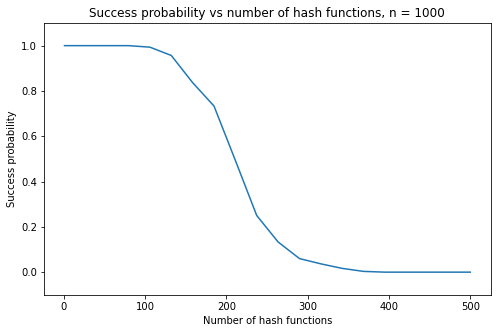

In [33]:
plt.plot(l_list, 1 - np.array(failure_prob))
plt.title(f"Success probability vs number of hash functions, n = {n}")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
# plt.xscale("log")
plt.xlabel("Number of hash functions")
plt.ylabel("Success probability")
plt.show()

### Number of queries vs $1/\delta$

In [49]:
points = np.repeat(np.random.binomial(1, 0.5, size=d)[:, None], n, axis=1).T
# np.ones((n, d), dtype=int)

nn_checker = skln.KDTree(points, metric='l1')
lsh = HammingLSH(points, r1, r2, delta)

In [70]:
delta_list = np.logspace(1, 13, 13, endpoint=True, base=1/np.e)

delta_res = []

for cur_delta in tqdm(delta_list):
    iters_per_point = 100
    cur_res = []
    for i in range(iters_per_point):
        lsh = HammingLSH(points, r1, r2, delta=cur_delta)
        cur_res.append(run_exp_fast(points[0], r1, nn_checker, lsh, max_resamples=30))
    delta_res.append(cur_res)

  0%|          | 0/13 [00:00<?, ?it/s]

In [71]:
zero_points = np.zeros((n, d), dtype=int)
    
delta_rand_res = []
for cur_delta in tqdm(delta_list):
    repeats = 10000
    iters_per_point = 100
    cur_res = []
    lsh = HammingLSH(zero_points, r1, r2, delta=cur_delta)
    for i in range(iters_per_point):
        success = 0
        for j in range(repeats):
            q = np.zeros(d, dtype=int)
            q[rng.choice(d, r1 - 1, replace=False)] = 1
            res = lsh.query(q)
            if res is None:
                success = True
                break
        cur_res.append((success, j + 1, l1_norm(q), q.copy()))
    delta_rand_res.append(cur_res)

  0%|          | 0/13 [00:00<?, ?it/s]

In [72]:
failure_prob = []
mean_queries = np.zeros(len(delta_res))
err_queries = np.zeros(len(delta_res))
# bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(delta_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

In [73]:
rand_failure_prob = []
rand_mean_queries = np.zeros(len(delta_rand_res))
rand_err_queries = np.zeros(len(delta_rand_res))
# bars_queries = [np.zeros(len(r_res)), np.zeros(len(r_res))]
for i, v in enumerate(delta_rand_res):
    f_pr = sum(1 - e[0] for e in v) / len(v)
    rand_failure_prob.append(f_pr)
    queries = [e[1] for e in v]
    rand_mean_queries[i] = np.mean(queries)
#     bars_queries[0][i] = np.percentile(queries, 90)
#     bars_queries[1][i] = np.percentile(queries, 10)
    rand_err_queries[i] = np.std(queries)


# bars_queries[0] -= mean_queries
# bars_queries[1] = mean_queries - bars_queries[1]

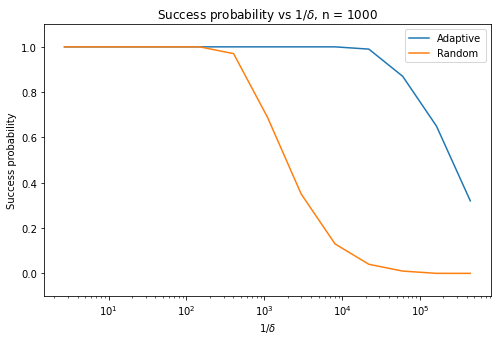

<ipython-input-81-51f68534f1eb>:14: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")


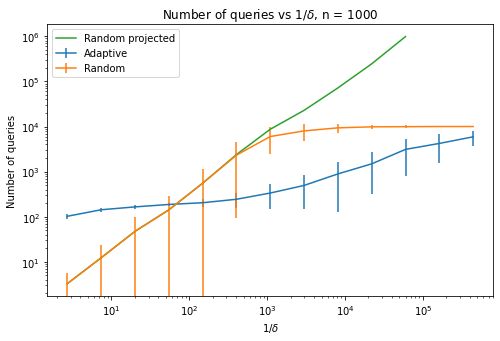

<ipython-input-81-51f68534f1eb>:25: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")


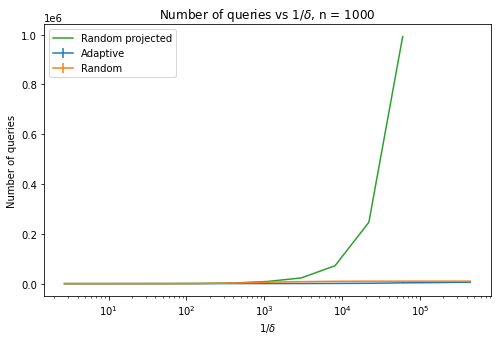

In [81]:
plt.plot(1 / delta_list, 1 - np.array(failure_prob), label="Adaptive")
plt.plot(1 / delta_list, 1 - np.array(rand_failure_prob), label="Random")
plt.legend()
plt.title(f"Success probability vs $1/\delta$, n = {n}")
plt.ylim(-0.1, 1.1)
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("$1 / \delta$")
plt.ylabel("Success probability")
plt.show()

plt.errorbar(1 / delta_list, mean_queries, yerr=err_queries, label="Adaptive")
plt.errorbar(1 / delta_list, rand_mean_queries, yerr=rand_err_queries, label="Random")
plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
plt.legend()
plt.title(f"Number of queries vs $1/\delta$, n = {n}")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("$1 / \delta$")
plt.ylabel("Number of queries")
plt.show()

plt.errorbar(1 / delta_list, mean_queries, yerr=err_queries, label="Adaptive")
plt.errorbar(1 / delta_list, rand_mean_queries, yerr=rand_err_queries, label="Random")
plt.plot(1 / delta_list, rand_mean_queries / (1 - np.array(rand_failure_prob)), label="Random projected")
plt.legend()
plt.title(f"Number of queries vs $1/\delta$, n = {n}")
# plt.yscale("log")
plt.xscale("log")
plt.xlabel("$1 / \delta$")
plt.ylabel("Number of queries")
plt.show()

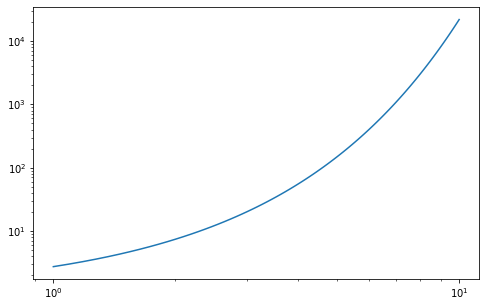

In [69]:
plt.plot(np.linspace(1, 10, 100), np.exp(np.linspace(1, 10, 100)))
plt.xscale("log")
plt.yscale("log")
plt.show()

# Size of $G(q,z)$

In [6]:
t = 10

In [7]:
print(r1, r2, t, n, d)

30 60 10 1000 300


In [11]:
points = np.zeros((n, d))

z = np.zeros(d)

In [29]:
grid = np.arange(0, r2)

num_samples = 10
res = []
for dist in tqdm(grid):
    q = np.zeros(d)
    q[:dist] = 1
    cur_res = []
    for i in range(num_samples):
        lsh = HammingLSH(points, r1, r2, delta)
        cur_res.append(lsh.cnt_mutual_buckets(q, z))
    res.append(cur_res)

  0%|          | 0/60 [00:00<?, ?it/s]

In [40]:
frac_res = np.array(res) / lsh._l
means = np.mean(frac_res, axis=1)
err = np.std(frac_res, axis=1)

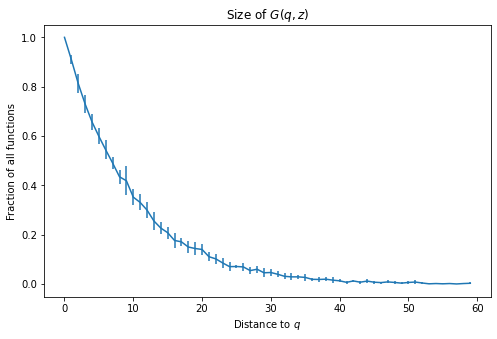

In [42]:
plt.errorbar(grid, means, yerr=err)
# plt.yscale("log")
plt.title("Size of $G(q, z)$")
plt.xlabel("Distance to $q$")
plt.ylabel("Fraction of all functions")
plt.show()